In [119]:
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import numpy as np

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets 
from torchvision import transforms

# General settings and normalization tools

In [ ]:
batch_size        = 128
device            = torch.device('cuda')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [3]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))    

# Data loading

In [128]:
cifar_cats = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        '../data',
        train = True,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(means, stds)
            ]
        )
    ),
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified


In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        '../data',
        train = False,
        download = True,
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(means, stds)
            ]
        )
    ),
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


# Training and evaluation tools

In [6]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y       = X.to(device), y.to(device)
            optimizer.zero_grad()
            *_, y_pred = model(X)
            loss       = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [7]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y             = X.to(device), y.to(device)
            *_, y_pred       = model(X)
            class_pred       = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss        += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

# Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3 , 32 , 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32 , 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64,  3, padding = 1)
        self.conv4 = nn.Conv2d(64, 64,  3, padding = 1)
        self.fc1   = nn.Linear(64 * 8 * 8, 128)
        self.fc2   = nn.Linear(128      , 10)
        
    def forward(self, x):
        out_conv1 = F.dropout(F.relu(self.conv1(x)), 0.2)
        out_conv2 = F.dropout(F.relu(self.conv2(out_conv1)), 0.2)
        out_pool1 = F.max_pool2d(out_conv2, kernel_size = (2, 2))
        out_conv3 = F.dropout(F.relu(self.conv3(out_pool1)), 0.2)
        out_conv4 = F.dropout(F.relu(self.conv4(out_conv3)), 0.2)
        out_pool2 = F.max_pool2d(out_conv4, kernel_size = (2, 2))
        out_view  = out_pool2.view(-1, 64 * 8 * 8)
        out_fc    = F.dropout(F.relu(self.fc1(out_view)), 0.2)
        out       = self.fc2(out_fc)
        
        return out_conv1, out_conv2, out_conv3, out_conv4, out

# Training

In [9]:
cnn       = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())

In [10]:
train(cnn, device, train_loader, optimizer, criterion, 10, len(train_loader) // 5)

Train epoch 0: [    0/50000] Loss:  2.3057
Train epoch 0: [ 9984/50000] Loss:  1.6067
Train epoch 0: [19968/50000] Loss:  1.6699
Train epoch 0: [29952/50000] Loss:  1.4609
Train epoch 0: [39936/50000] Loss:  1.2574
Train epoch 0: [31200/50000] Loss:  1.2374


Train epoch 1: [    0/50000] Loss:  1.3342
Train epoch 1: [ 9984/50000] Loss:  1.0797
Train epoch 1: [19968/50000] Loss:  1.0808
Train epoch 1: [29952/50000] Loss:  1.1353
Train epoch 1: [39936/50000] Loss:  1.1458
Train epoch 1: [31200/50000] Loss:  1.1648


Train epoch 2: [    0/50000] Loss:  0.9138
Train epoch 2: [ 9984/50000] Loss:  0.9239
Train epoch 2: [19968/50000] Loss:  0.9626
Train epoch 2: [29952/50000] Loss:  1.0711
Train epoch 2: [39936/50000] Loss:  0.8883
Train epoch 2: [31200/50000] Loss:  0.8562


Train epoch 3: [    0/50000] Loss:  0.6655
Train epoch 3: [ 9984/50000] Loss:  0.8226
Train epoch 3: [19968/50000] Loss:  0.8241
Train epoch 3: [29952/50000] Loss:  0.8261
Train epoch 3: [39936/50000] Loss:  0.7629
Train epoch 3: [31200/50000] Loss:  0.7052


Train epoch 4: [    0/50000] Loss:  0.7717
Train epoch 4: [ 9984/50000] Loss:  0.7865
Train epoch 4: [19968/50000] Loss:  0.7121
Train epoch 4: [29952/50000] Loss:  0.7660
Train epoch 4: [39936/50000] Loss:  0.7333
Train epoch 4: [31200/50000] Loss:  0.8016


Train epoch 5: [    0/50000] Loss:  0.6721
Train epoch 5: [ 9984/50000] Loss:  0.6131
Train epoch 5: [19968/50000] Loss:  0.5612
Train epoch 5: [29952/50000] Loss:  0.6122
Train epoch 5: [39936/50000] Loss:  0.6469
Train epoch 5: [31200/50000] Loss:  0.7741


Train epoch 6: [    0/50000] Loss:  0.6207
Train epoch 6: [ 9984/50000] Loss:  0.6021
Train epoch 6: [19968/50000] Loss:  0.6295
Train epoch 6: [29952/50000] Loss:  0.5937
Train epoch 6: [39936/50000] Loss:  0.5132
Train epoch 6: [31200/50000] Loss:  0.5498


Train epoch 7: [    0/50000] Loss:  0.4962
Train epoch 7: [ 9984/50000] Loss:  0.5766
Train epoch 7: [19968/50000] Loss:  0.4374
Train epoch 7: [29952/50000] Loss:  0.5484
Train epoch 7: [39936/50000] Loss:  0.6458
Train epoch 7: [31200/50000] Loss:  0.5713


Train epoch 8: [    0/50000] Loss:  0.4006
Train epoch 8: [ 9984/50000] Loss:  0.6771
Train epoch 8: [19968/50000] Loss:  0.5519
Train epoch 8: [29952/50000] Loss:  0.4595
Train epoch 8: [39936/50000] Loss:  0.5902
Train epoch 8: [31200/50000] Loss:  0.5606


Train epoch 9: [    0/50000] Loss:  0.5210
Train epoch 9: [ 9984/50000] Loss:  0.4436
Train epoch 9: [19968/50000] Loss:  0.5590
Train epoch 9: [29952/50000] Loss:  0.4084
Train epoch 9: [39936/50000] Loss:  0.4767
Train epoch 9: [31200/50000] Loss:  0.4151



In [11]:
accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


[Train] Accuracy: 84.11%, loss:  0.4323



[Test] Accuracy: 73.07%, loss:  0.8435


Real label: 1
Predicted label: 1


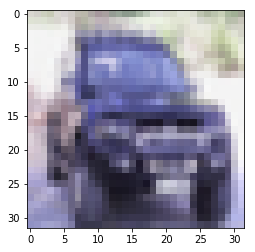

In [12]:
X, y  = next(iter(test_loader))
X     = X.to(device)
ex_id = 9
img   = X[ex_id].permute(1,2,0)
img   = reverse_normalize(img)
plt.imshow(img.cpu())
print(f'Real label: {y[ex_id].item()}')
print(f'Predicted label: {cnn(X.to(device))[-1][ex_id].argmax().item()}')

# Adversarial examples

In [13]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    *_, y_pred      = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    
    # Clamping the result to [0, 1] in each channel.
    # I don't think that there exist a multidimensional clamp function.
    for channel, norm_func in enumerate([normalize_red, normalize_green, normalize_blue]):
        adv_example[:, channel, ...].clamp_(norm_func(0), norm_func(1))
    
    return adv_example

In [14]:
def adv_sample_process(model, epsilon, ex_idx, X, y):
    source       = X[ex_idx, ...].unsqueeze(0).to(device)
    *_, y_pred   = model(source)
    adv_example  = generate_adv_example(model, epsilon, criterion, source)
    *_, adv_pred = cnn(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {y[ex_idx].item()}')
    print(f'Predicted label: {adv_pred[0].argmax().item()}')

Class 0: -5.1658 	->	 -15.3131
Class 1: -8.2507 	->	 -16.5636
Class 2: 1.0376 	->	 4.7020
Class 3: 4.8733 	->	 2.8609
Class 4: 1.3010 	->	 6.8548
Class 5: 2.7794 	->	 0.5654
Class 6: 7.2541 	->	 18.0676
Class 7: -4.9976 	->	 -11.6801
Class 8: -10.4775 	->	 -17.9306
Class 9: -5.8556 	->	 -17.3234
Real label: 6
Predicted label: 6


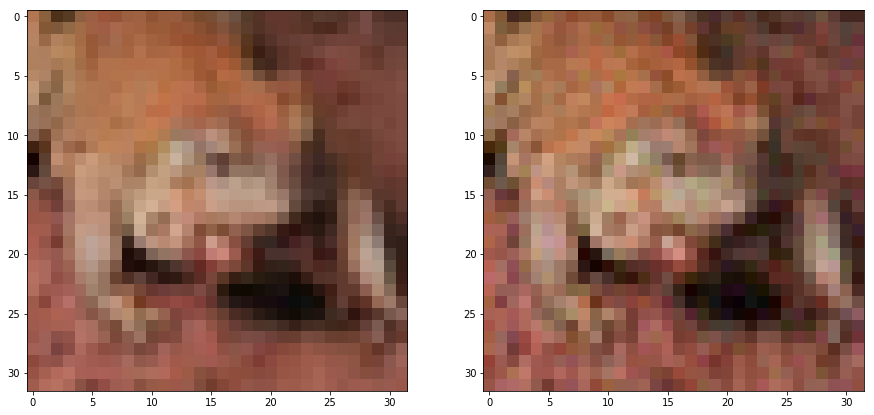

In [15]:
adv_sample_process(cnn, 0.15, 5, X, y)

# KNN experimentations

In [110]:
conv_features = [[] for _ in range(4)]
targets       = []
predictions   = []
c = 0
for X, y in train_loader:
    X                  = X.to(device)
    *out_convs, y_pred = cnn(X)
    for i, out_conv in enumerate(out_convs):
        conv_feat = out_conv.view(out_conv.size(0), -1).cpu().detach().numpy()
        conv_features[i].append(conv_feat)
    targets.append(y.numpy())
    predictions.append(y_pred.cpu().detach().numpy())
    if c == 5:
        break
    c += 1

In [111]:
conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
targets       = np.concatenate(targets)
predictions   = np.concatenate(predictions, axis = 0)
print([conv_feat.shape for conv_feat in conv_features])
print(targets.shape)
print(predictions.shape)

# Plots

In [122]:
X = conv_features[-1]

In [123]:
pca = PCA(n_components = 2)
X_trans = pca.fit_transform(X)

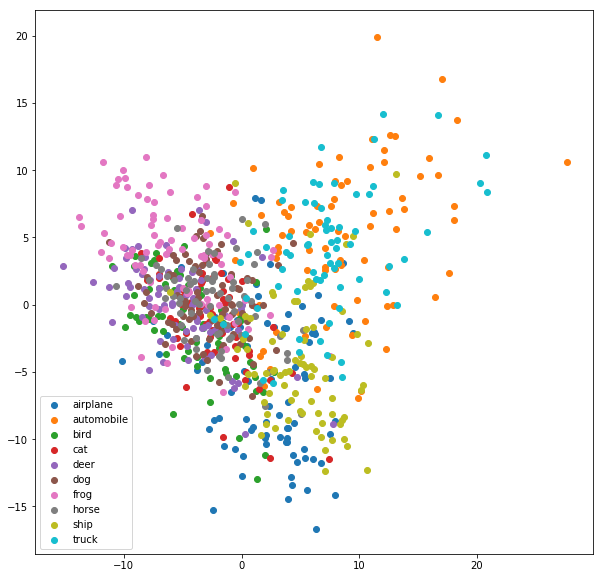

In [135]:
plt.figure(figsize = (10, 10))
for i, category in enumerate(cifar_cats):
    category_inputs = X_trans[targets == i]
    plt.scatter(category_inputs[:, 0], category_inputs[:, 1], label = category)
plt.legend()

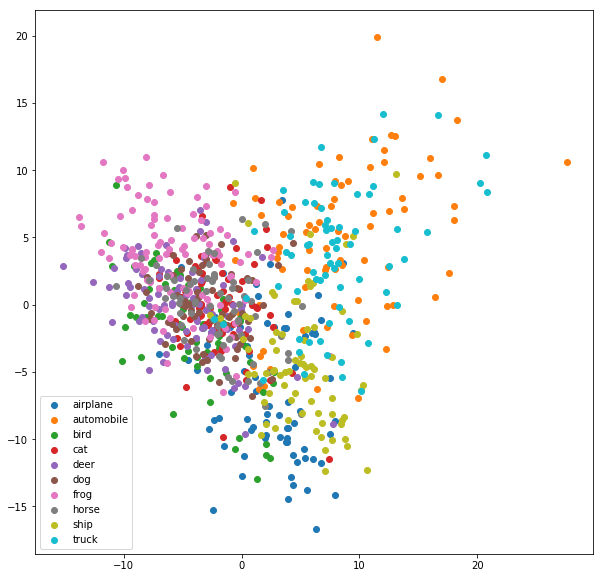

In [136]:
plt.figure(figsize = (10, 10))
for i, category in enumerate(cifar_cats):
    category_inputs = X_trans[np.argmax(predictions, axis = 1) == i]
    plt.scatter(category_inputs[:, 0], category_inputs[:, 1], label = category)
plt.legend()